#<b><center>EDA review-Utah</b></center>

Importacion de librerías

In [1]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import os
import json
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from google.cloud import storage
import pyarrow.parquet as pq
from google.colab import auth
auth.authenticate_user()

Montando carpeta drive.

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/datalake/reviews-estados/review-Utah
archivos = os.listdir()
df = pd.DataFrame()
for archivo in archivos:
    if archivo.endswith('.json'):  # Puedes ajustar la extensión según tus necesidades
        print('Cargando data ',archivo,'...')
        data = pd.read_json(archivo, lines=True)
        #df.append(data)
        df = pd.concat([df, data], axis=0)


/content/drive/MyDrive/datalake/reviews-estados/review-Utah
Cargando data  7.json ...
Cargando data  2.json ...
Cargando data  3.json ...
Cargando data  10.json ...
Cargando data  8.json ...
Cargando data  9.json ...
Cargando data  5.json ...
Cargando data  4.json ...
Cargando data  6.json ...
Cargando data  1.json ...


Se verifica el tipo de variable de cada columna en caso sea necesario cambiarlo.

In [4]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   user_id  1500000 non-null  float64
 1   name     1500000 non-null  object 
 2   time     1500000 non-null  int64  
 3   rating   1500000 non-null  int64  
 4   text     935940 non-null   object 
 5   pics     49380 non-null    object 
 6   resp     251615 non-null   object 
 7   gmap_id  1500000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 103.0+ MB


,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.121150e+20,sofia v,1608234428884,5,Every time I have come into this location ever...,None,None,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
1,1.054794e+20,Sarah Noot,1550599817534,1,Horrible service.\nI schedule my package for p...,None,None,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
2,1.154436e+20,R People,1549829149516,1,Mail carrier broke my front porch light. Tryin...,None,None,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
3,1.136965e+20,Carley Prestwich,1475595966444,5,Great experience here ! Friendly and helpful e...,None,None,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
4,1.056595e+20,Micki Hays,1549656200603,1,Me and my neighbor removed the front Fence bet...,None,None,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2


In [5]:
df['user_id'] = df['user_id'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1500000 non-null  object
 1   name     1500000 non-null  object
 2   time     1500000 non-null  int64 
 3   rating   1500000 non-null  int64 
 4   text     935940 non-null   object
 5   pics     49380 non-null    object
 6   resp     251615 non-null   object
 7   gmap_id  1500000 non-null  object
dtypes: int64(2), object(6)
memory usage: 103.0+ MB


<b>Filtrado de columnas</b>

Se selecciona solo las columnas que pueden contener información relevante para el análisis.
- "pics" : no se realiza un análisis de imágenes
- "resp": son respuestas de los desarrolladores, generalmente de agredecimiento de los comentarios.

In [6]:
df_analisis = df[['user_id','name','time','rating','text','gmap_id']]
df_analisis.head()

,user_id,name,time,rating,text,gmap_id
0,112114976874557997056.0,sofia v,1608234428884,5,Every time I have come into this location ever...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
1,105479388716990169088.0,Sarah Noot,1550599817534,1,Horrible service.\nI schedule my package for p...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
2,115443555820357632000.0,R People,1549829149516,1,Mail carrier broke my front porch light. Tryin...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
3,113696494334557257728.0,Carley Prestwich,1475595966444,5,Great experience here ! Friendly and helpful e...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
4,105659485490984648704.0,Micki Hays,1549656200603,1,Me and my neighbor removed the front Fence bet...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2


<b>Analizando las columnas numéricas</b>
- "time" se entiende como el número de registro.
- "rating" es la puntuación del usuario de 1 a 5, su variación se encuentra en ese rango

In [7]:
df_analisis.describe()

,time,rating
count,1.500000e+06,1.500000e+06
mean,1.550909e+12,4.323863e+00
std,4.453958e+10,1.127515e+00
min,1.181261e+12,1.000000e+00
25%,1.522791e+12,4.000000e+00
50%,1.554916e+12,5.000000e+00
75%,1.581821e+12,5.000000e+00
max,1.630987e+12,5.000000e+00


<b>Filtros complementarios</b>

Posibles duplicados y nulos. El uso de memoria se reduce a 41.8 Mb

In [8]:
df_analisis.dropna(inplace=True)
df_analisis.drop_duplicates(inplace=True)
df_analisis.reset_index(drop=True,inplace=True)
df_analisis.info()
df_analisis.head(5)

<ipython-input-8-d87d968368bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis.dropna(inplace=True)
<ipython-input-8-d87d968368bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913525 entries, 0 to 913524
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  913525 non-null  object
 1   name     913525 non-null  object
 2   time     913525 non-null  int64 
 3   rating   913525 non-null  int64 
 4   text     913525 non-null  object
 5   gmap_id  913525 non-null  object
dtypes: int64(2), object(4)
memory usage: 41.8+ MB


,user_id,name,time,rating,text,gmap_id
0,112114976874557997056.0,sofia v,1608234428884,5,Every time I have come into this location ever...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
1,105479388716990169088.0,Sarah Noot,1550599817534,1,Horrible service.\nI schedule my package for p...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
2,115443555820357632000.0,R People,1549829149516,1,Mail carrier broke my front porch light. Tryin...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
3,113696494334557257728.0,Carley Prestwich,1475595966444,5,Great experience here ! Friendly and helpful e...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2
4,105659485490984648704.0,Micki Hays,1549656200603,1,Me and my neighbor removed the front Fence bet...,0x87528c3a3c5eef47:0x6de2ac4b0d5d39c2


La media indica un valor de 4.3 puntos, lo que habla muy bien de los locales en Utah con 0.9 millones de reviews de respaldo.

In [9]:
df_analisis.describe()

,time,rating
count,9.135250e+05,913525.000000
mean,1.548605e+12,4.301432
std,4.712770e+10,1.206352
min,1.189260e+12,1.000000
25%,1.518920e+12,4.000000
50%,1.553121e+12,5.000000
75%,1.582323e+12,5.000000
max,1.630987e+12,5.000000


<b>Pairplot</b>

Como era de suponerse, la puntuación es discreta entre 1 y 5.

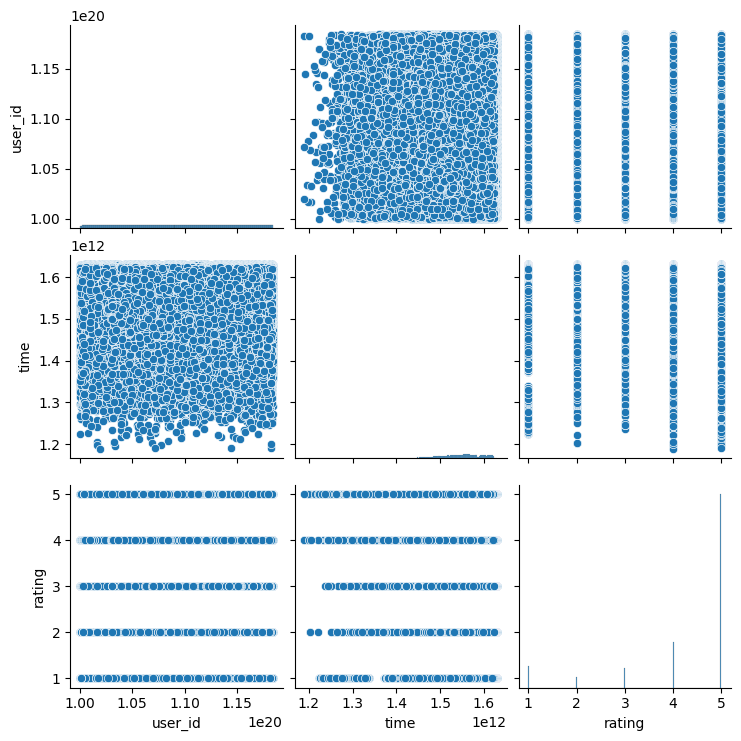

In [10]:
sns.pairplot(df_analisis)

Del pairplot se aprecian outliers de la columna 'time', por cual se realiza un análisis de la columna para eliminar valores atípicos

Text(0.5, 0, 'Tiempo de registro')

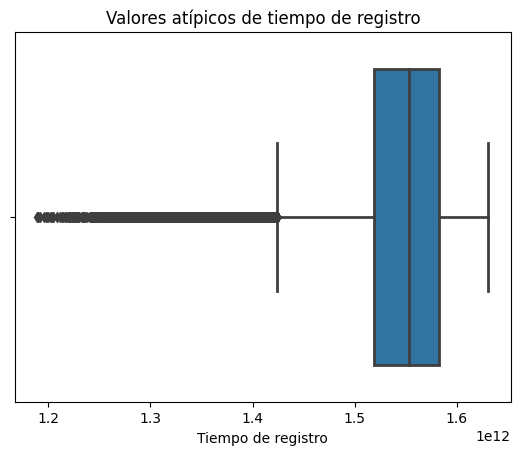

In [11]:
ax = sns.boxplot( x ="time",data = df_analisis, linewidth = 2)

ax.set_title('Valores atípicos de tiempo de registro')
ax.set_xlabel('Tiempo de registro')

Se extraen los valores atípicos. Con 3 desviaciones estándar se aseguro solo descartar los valores atípicos.



In [12]:
z_scores = zscore(df_analisis['time'])
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = df_analisis[abs_z_scores > 3]
df_analisis = df_analisis[abs_z_scores <= 3]
outliers.head()
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8277 entries, 11 to 913416
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  8277 non-null   object
 1   name     8277 non-null   object
 2   time     8277 non-null   int64 
 3   rating   8277 non-null   int64 
 4   text     8277 non-null   object
 5   gmap_id  8277 non-null   object
dtypes: int64(2), object(4)
memory usage: 452.6+ KB


La columna 'time' no tiene mayor uso que este análisis, para ahorrar memoria se descartará

In [13]:
df_analisis.drop(columns=['time'],inplace=True)
df_analisis.drop_duplicates(inplace=True)
df_analisis.reset_index(drop=True,inplace=True)

<ipython-input-13-f97d05965a14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis.drop(columns=['time'],inplace=True)
<ipython-input-13-f97d05965a14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis.drop_duplicates(inplace=True)


In [14]:
df_analisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905248 entries, 0 to 905247
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  905248 non-null  object
 1   name     905248 non-null  object
 2   rating   905248 non-null  int64 
 3   text     905248 non-null  object
 4   gmap_id  905248 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.5+ MB


In [15]:
ratings_count = df_analisis[['rating','user_id']].groupby(by='rating', as_index=False).count().sort_values(by='rating', ascending=True)
ratings_count

,rating,user_id
0,1,67074
1,2,32275
2,3,61078
3,4,142808
4,5,602013


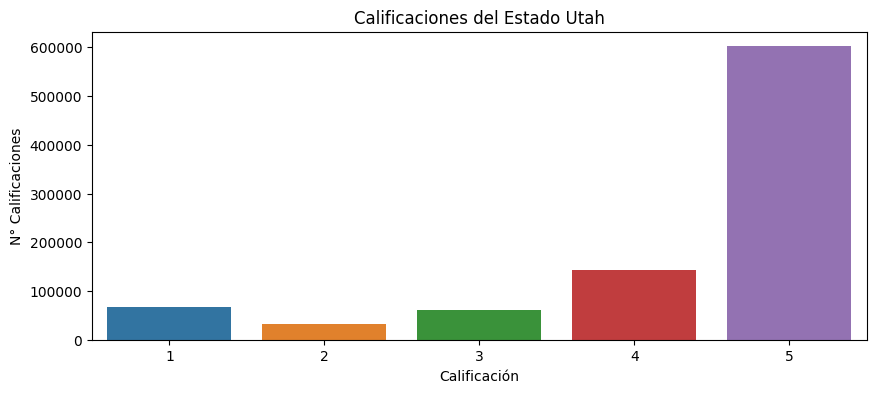

In [16]:
plt.figure(figsize=(10,4), dpi=100)
sns.barplot(data=ratings_count, x='rating', y='user_id')
plt.xlabel('Calificación')
plt.ylabel('N° Calificaciones')
plt.title("Calificaciones del Estado Utah")

plt.show()

Dividiendo en dataframes más pequeños y guardando lo obtenido:



In [17]:
users = df_analisis[['user_id','name']]
users.drop_duplicates(inplace=True)
users.reset_index(drop=True,inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142132 entries, 0 to 142131
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  142132 non-null  object
 1   name     142132 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


<ipython-input-17-399b2f488d99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.drop_duplicates(inplace=True)


In [18]:
ratings = df_analisis[['user_id','gmap_id','rating']]
ratings.drop_duplicates(inplace=True)
ratings.reset_index(drop=True,inplace=True)
ratings.info()

<ipython-input-18-5649e09075a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905214 entries, 0 to 905213
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  905214 non-null  object
 1   gmap_id  905214 non-null  object
 2   rating   905214 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 20.7+ MB


In [19]:
reviews = df_analisis[['user_id','gmap_id','text']]
ratings.drop_duplicates(inplace=True)
ratings.reset_index(drop=True,inplace=True)
ratings.info()

<ipython-input-19-291d10382b00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905214 entries, 0 to 905213
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  905214 non-null  object
 1   gmap_id  905214 non-null  object
 2   rating   905214 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 20.7+ MB


In [20]:
users.to_parquet('users.parquet')
ratings.to_parquet('ratings.parquet')
reviews.to_parquet('reviews.parquet')

Guardado en datalake de Google Storage:

In [21]:
project_id = 'deep-wave-407518'
bucket_name = 'yelp-and-maps-data-processed'


In [22]:
# Google Storage user.parquet
# Configura el cliente de almacenamiento
client = storage.Client(project=project_id)

# Obtén el bucket
bucket = client.get_bucket(bucket_name)

# Define la ruta del archivo Parquet en Google Cloud Storage
gcs_path = 'Maps/reviews-estados/review-Utah/users.parquet'.format(bucket_name)

# Sube el archivo Parquet a Google Cloud Storage
blob = bucket.blob(gcs_path)
blob.upload_from_filename('users.parquet')


In [23]:
# Google Storage user.parquet
# Configura el cliente de almacenamiento
client = storage.Client(project=project_id)

# Obtén el bucket
bucket = client.get_bucket(bucket_name)

# Define la ruta del archivo Parquet en Google Cloud Storage
gcs_path = 'Maps/reviews-estados/review-Utah/ratings.parquet'.format(bucket_name)

# Sube el archivo Parquet a Google Cloud Storage
blob = bucket.blob(gcs_path)
blob.upload_from_filename('ratings.parquet')

In [24]:
# Google Storage user.parquet
# Configura el cliente de almacenamiento
client = storage.Client(project=project_id)

# Obtén el bucket
bucket = client.get_bucket(bucket_name)

# Define la ruta del archivo Parquet en Google Cloud Storage
gcs_path = 'Maps/reviews-estados/review-Utah/reviews.parquet'.format(bucket_name)

# Sube el archivo Parquet a Google Cloud Storage
blob = bucket.blob(gcs_path)
blob.upload_from_filename('reviews.parquet')